In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [3]:
import h5py

In [4]:
import seaborn as sns

In [5]:
from plotting_utils import *

In [6]:
# Home Ubuntu
# root_path = '/media/akumar/54949792949774E8/Users/akumar/nse/uoicorr_analysis/notebooks/sfn'

# Lab
root_path = '/mnt/sdb1'

In [9]:
lasso_engine = sqlalchemy.create_engine('sqlite:////%s/lasso.db' % root_path)
lasso_con = lasso_engine.connect()
mcp_engine = sqlalchemy.create_engine('sqlite:////%s/scad.db' % root_path)
mcp_con = mcp_engine.connect()
scad_engine = sqlalchemy.create_engine('sqlite:////%s/mcp.db' % root_path)
scad_con = scad_engine.connect()

uoi_engine = sqlalchemy.create_engine('sqlite:////%s/uoi.db' % root_path)
uoi_con = uoi_engine.connect()

en_engine = sqlalchemy.create_engine('sqlite:////%s/en.db' % root_path)
en_con = en_engine.connect()

In [10]:
# These guys are small enough to live in memory
lasso = pd.read_sql_table('pp_df', lasso_con)
mcp = pd.read_sql_table('pp_df', mcp_con)
scad = pd.read_sql_table('pp_df', scad_con)

uoi = pd.read_sql_table('pp_df', uoi_con)
en = pd.read_sql_table('pp_df', en_con)

In [11]:
sparsity = np.unique(uoi['sparsity'].values)

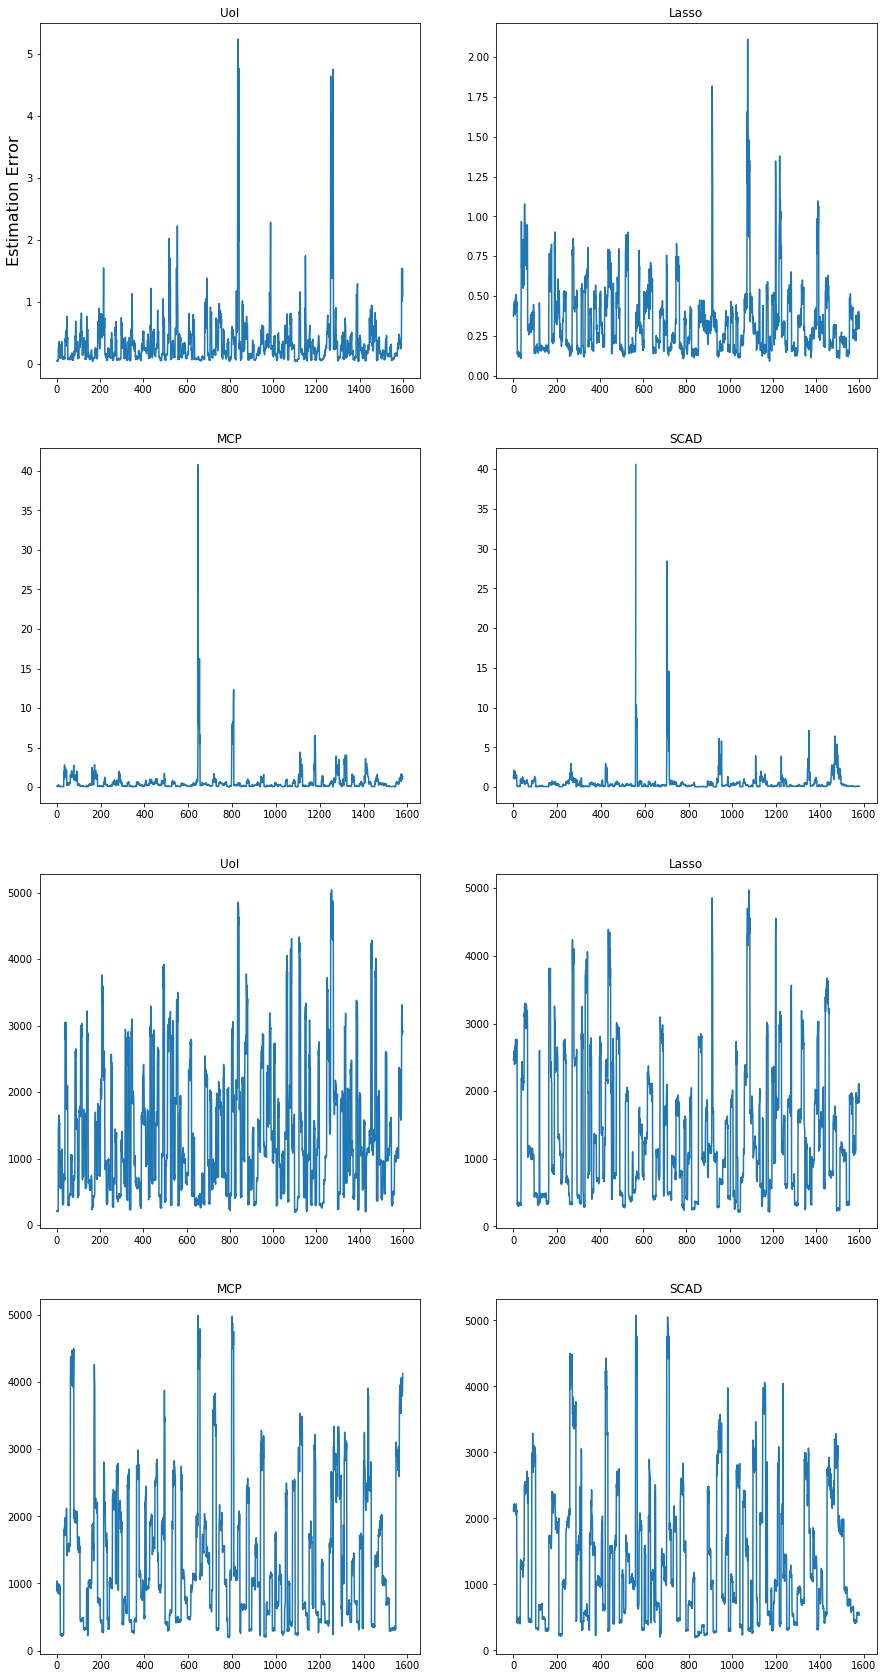

In [13]:
# Plot R2 and MSE when the supposed bias/variance is very high, esp. for SCAD/MCP

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
k = 5
kappa = np.unique(uoi['kappa'].values)
bw = np.inf
selection_method = 'BIC'

dframes = [uoi, lasso, mcp, scad]
#dframes = [uoi, en]
dframe_names = ['UoI', 'Lasso', 'MCP', 'SCAD']

fig, ax = plt.subplots(4, 2, figsize = (15, 30))

for i3, dframe in enumerate(dframes):

    a = ax[np.unravel_index(i3, (4, 2))]
    
    df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, sparsity = sparsity[5],
                          betawidth=bw, selection_method=selection_method)
    # Plot by unique_cov_params
    ucp, cidxs = unique_cov_params(df)
    values = df['ee'].values
    # order by average correlation
    avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
    cov_order = np.argsort(avg_cov)
    a.plot(values)
    a.set_title(dframe_names[i3])
    
ax[0, 0].set_ylabel('Estimation Error', fontsize = 16)

# Estimation variance 

# Select indices
for i3, dframe in enumerate(dframes):
    ui = np.unravel_index(i3, (4, 2))
    a = ax[2 + ui[0], ui[1]]
    
    df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, sparsity=sparsity[5], 
                          betawidth=bw, selection_method=selection_method)

    # Plot by unique_cov_params
    ucp, cidxs = unique_cov_params(df)
    values = df['MSE'].values
    # order by average correlation
    avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
    cov_order = np.argsort(avg_cov)
    a.plot(values)
    a.set_title(dframe_names[i3])
    
# ax[4, 0].set_ylabel('MSE', fontsize = 16)

In [ ]:
# These results look reasonable, in that there are particular failure modes, but otherwise things work out or 
# are at least comparable across algorithms

# Next, take a look at the SCAD bias/variance and see whether it matches up with our previous plots to debug
# whether there is something funky up with the way we are calculating things or whether the effect is real

# Do some interactive fits - does SCAD/MCP really demonstrate lower average bias than UoI. What about UoI 
# variance relative to Lasso?

# To potentially deal with this:
# Use some l2 regularization in the estimation module

In [8]:
# Load up the test fits
 
scad2 = pd.read_pickle('%s/biastest/scad_pp.dat' % root_path)
lasso2 = pd.read_pickle('%s/biastest/lasso_pp.dat' % root_path)
uoi2 = pd.read_pickle('%s/biastest/uoi_pp.dat' % root_path)

scadb = h5py.File('%s/biastest/scad_pp_beta.h5' % root_path, 'r')
lassob = h5py.File('%s/biastest/lasso_pp_beta.h5' % root_path, 'r')
uoib = h5py.File('%s/biastest/uoi_pp_beta.h5' % root_path, 'r')

In [9]:
sparsity = np.unique(scad2['sparsity'].values)

In [10]:
def bias_from_file(beta_file, indices):
    
    bias = np.zeros(len(indices))
    
    first_hit = False
    
    for i, idx in enumerate(indices):
        bias[i] = np.linalg.norm(beta_file['beta_hat'][idx, :] - beta_file['beta'][idx, :])
        if bias[i] == 0 and not first_hit:
            print(i)
            first_hit = True
            
#     bias = np.array([np.linalg.norm(beta_file['beta_hat'][j, :] - beta_file['beta'][j, :])
#                      for j in indices])
    return bias        

In [11]:
# If the largest exponential lengthscale gives catastrophic failure, we should likely not use those matrices 
# as a basis for expanding the ensemble

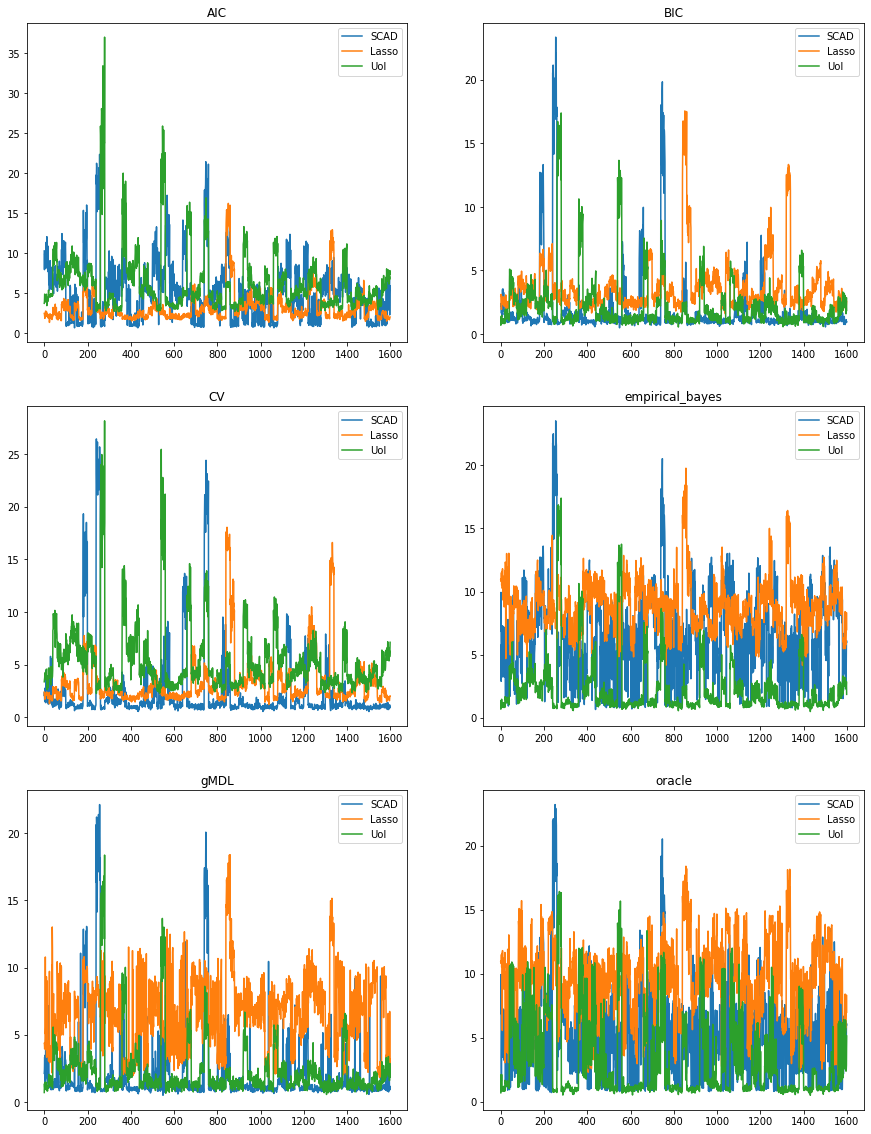

In [12]:
# Compare the bias/variances we obtain compared to the sfn results

# Bias
fig, ax = plt.subplots(3, 2, figsize = (15, 20))

dframes = [scad2, lasso2, uoi2]
dframe_names = ['SCAD', 'Lasso', 'UoI']
                
for i, sm in enumerate(np.unique(scad2['selection_method'].values)):

    a = ax[np.unravel_index(i, (3, 2))]
    
    for i2, df in enumerate(dframes):    
        df_ = apply_df_filters(df, selection_method=sm, sparsity=sparsity[0])
        values = df_['bias'].values
        a.plot(values, label=dframe_names[i2])
    a.set_title(sm)
    a.legend()

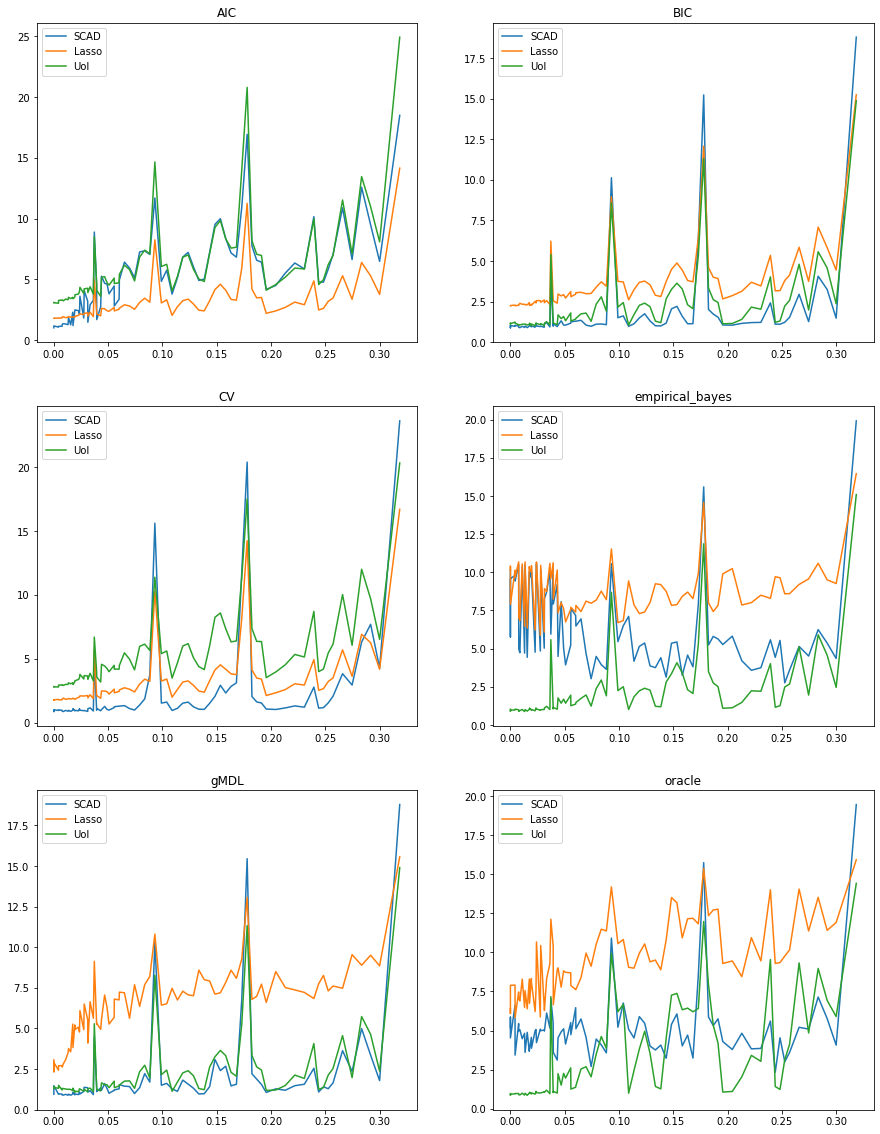

In [13]:
# Same plot, but average over reps

# Bias
fig, ax = plt.subplots(3, 2, figsize = (15, 20))

dframes = [scad2, lasso2, uoi2]
dframe_names = ['SCAD', 'Lasso', 'UoI']
                
for i, sm in enumerate(np.unique(scad2['selection_method'].values)):

    a = ax[np.unravel_index(i, (3, 2))]

    for i2, df in enumerate(dframes):    
        df_ = apply_df_filters(df, selection_method=sm, sparsity=sparsity[0])
        
        ucp, cidxs = unique_cov_params(df_)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)
        
        # Average values over cidxs
        values = df_['bias'].values 
        averaged_values = np.array([np.mean(values[cidx]) for cidx in cidxs])        
        a.plot(avg_cov[cov_order], averaged_values[cov_order], label=dframe_names[i2])
    a.set_title(sm)
    a.legend()


In [50]:
def common_support_bias(cfile, cidxs):
    
    result = np.zeros(len(cidxs))
    
    for i, cidx in enumerate(cidxs):
        raw = np.zeros(len(cidx))
        for j, idx in enumerate(cidx):
            b = cfile['beta'][idx, :]
            bhat = cfile['beta_hat'][idx, :]
            
            # Find the common support
            common_support = list(set(np.nonzero(b)[0]).intersection(set(np.nonzero(bhat)[0])))
            pdb.set_trace()
            common_support_bias = np.linalg.norm(bhat[common_support] - b[common_support])
            raw[j] = common_support_bias
        result[i] = np.mean(raw)        
    return result    

> <ipython-input-50-156579dba926>(14)common_support_bias()
-> common_support_bias = np.linalg.norm(bhat[common_support] - b[common_support])
(Pdb) common_support
[3, 4, 5, 13, 16, 18, 21, 24, 26, 27, 28, 30, 31, 32, 39, 43, 45, 50, 53, 62, 64, 70, 71, 72, 74, 77, 78, 79, 81, 83, 85, 87, 91, 93, 94, 102, 107, 115, 120, 121, 123, 127, 129, 132, 134, 139, 140, 146, 150, 151, 153, 156, 157, 162, 164, 166, 171, 173, 174, 177, 179, 183, 187, 188, 189, 192, 198, 199, 208, 213, 217, 225, 230, 231, 235, 237, 238, 239, 242, 243, 245, 248, 249, 252, 256, 261, 263, 265, 267, 272, 273, 279, 280, 282, 284, 285, 287, 289, 291, 295, 296, 300, 301, 302, 304, 308, 313, 320, 323, 325, 326, 328, 339, 341, 345, 346, 347, 352, 353, 363, 364, 371, 372, 374, 375, 379, 384, 385, 387, 388, 389, 391, 395, 396, 398, 400, 404, 408, 411, 412, 418, 420, 426, 428, 429, 430, 432, 435, 440, 441, 445, 446, 449, 453, 455, 457, 461, 467, 469, 477, 478, 481, 490, 491, 492, 494, 496]
(Pdb) len(common_support)
167
(Pdb) np.n

BdbQuit: 

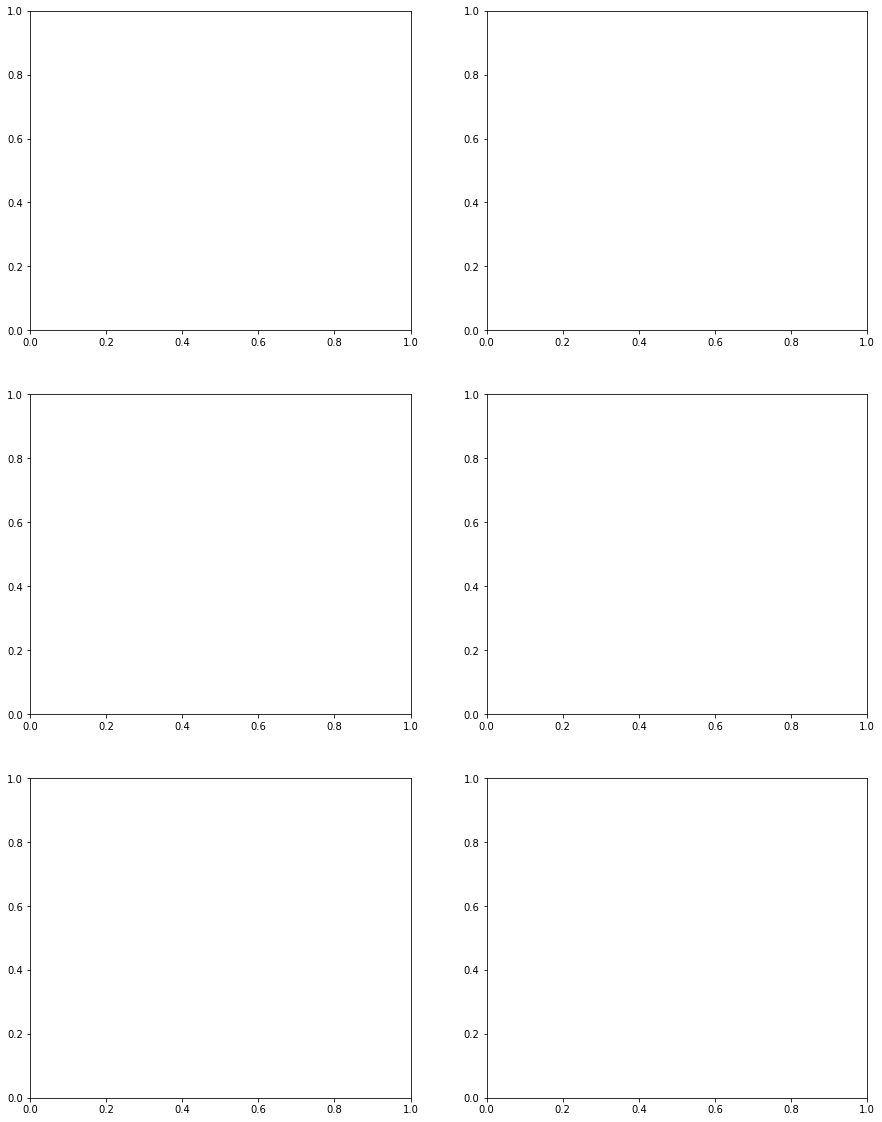

In [51]:
# Next, instead plot the normalized bias per element in the common support:

# Same plot, but average over reps

# Bias
fig, ax = plt.subplots(3, 2, figsize = (15, 20))

dframes = [scad2, lasso2, uoi2]
coeffs = [scadb, lassob, uoib]
dframe_names = ['SCAD', 'Lasso', 'UoI']
                
for i, sm in enumerate(np.unique(scad2['selection_method'].values)):

    a = ax[np.unravel_index(i, (3, 2))]

    for i2, df in enumerate(dframes):    
        df_ = apply_df_filters(df, selection_method=sm, sparsity=sparsity[0])
        ucp, cidxs = unique_cov_params(df_)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)
        values = common_support_bias(coeffs[i2], cidxs)
        a.plot(avg_cov[cov_order], values[cov_order], '-o', label=dframe_names[i2])

    a.set_title(sm)
    a.legend()


In [27]:
def bias_per_entry(cfile, cidxs):
    
    result = np.zeros(len(cidxs))
    
    for i, cidx in enumerate(cidxs):
        raw = np.zeros(len(cidx))
        for j, idx in enumerate(cidx):
            b = cfile['beta'][idx, :]
            bhat = cfile['beta_hat'][idx, :]
            
            # Find the common support
            common_support = list(set(np.nonzero(b)[0]).intersection(set(np.nonzero(bhat)[0])))
            
            common_support_bias = np.linalg.norm(bhat[common_support] - b[common_support])
            raw[j] = common_support_bias/len(common_support)
        result[i] = np.mean(raw)
    
    return result

In [28]:
def normalized_bias(cfile, cidxs):
    result = np.zeros(len(cidxs))

    for i, cidx in enumerate(cidxs):
        raw = np.zeros(len(cidx))
        for j, idx in enumerate(cidx):
            b = cfile['beta'][idx, :]
            bhat = cfile['beta_hat'][idx, :]
            
            # Find the common support
            common_support = list(set(np.nonzero(b)[0]).intersection(set(np.nonzero(bhat)[0])))
            
            common_support_bias = np.linalg.norm(bhat[common_support] - b[common_support])
            raw[j] = common_support_bias/np.linalg.norm(b[common_support])
        result[i] = np.mean(raw)
    
    return result

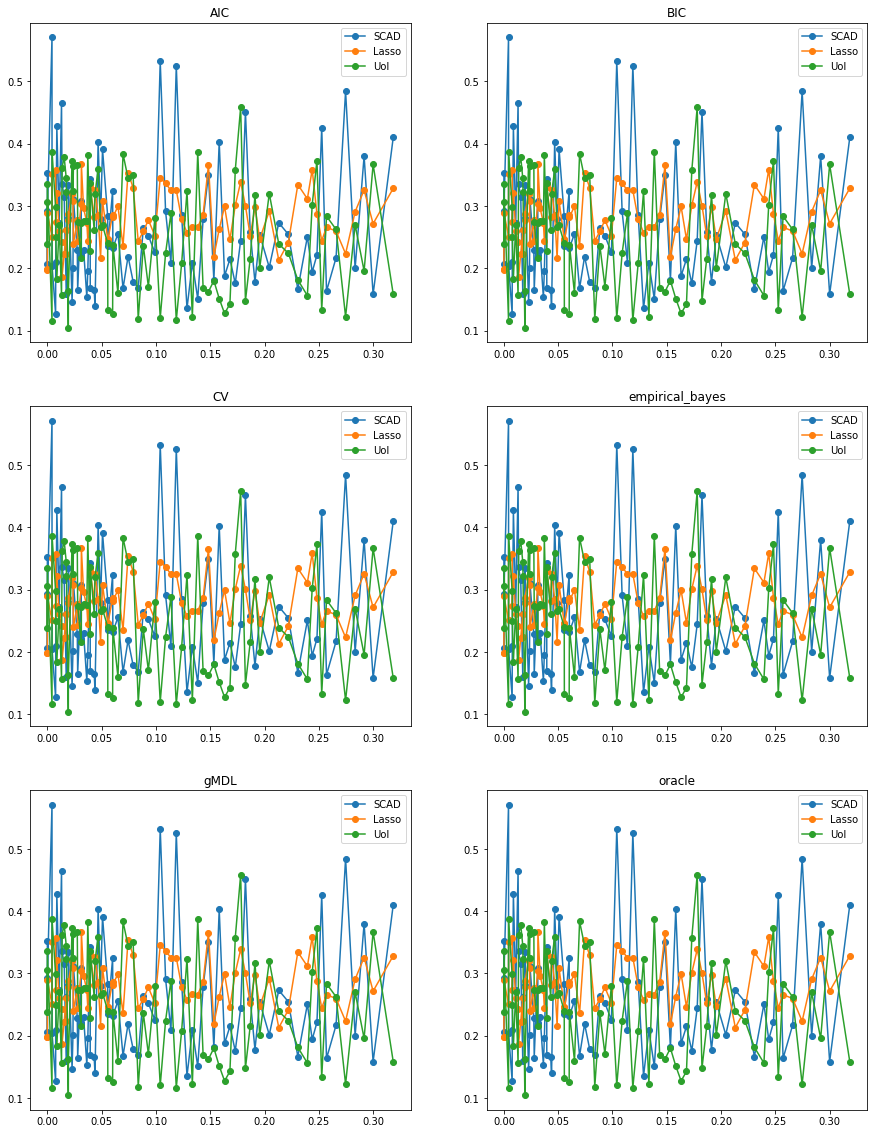

In [45]:
# Next, instead plot the normalized bias per element in the common support:

# Same plot, but average over reps

# Bias
fig, ax = plt.subplots(3, 2, figsize = (15, 20))

dframes = [scad2, lasso2, uoi2]
coeffs = [scadb, lassob, uoib]
dframe_names = ['SCAD', 'Lasso', 'UoI']
                
for i, sm in enumerate(np.unique(scad2['selection_method'].values)):

    a = ax[np.unravel_index(i, (3, 2))]

    for i2, df in enumerate(dframes):    
        df_ = apply_df_filters(df, selection_method=sm, sparsity=sparsity[0])

        ucp, cidxs = unique_cov_params(df_)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)
        values = bias_per_entry(coeffs[i2], cidxs)
        a.plot(avg_cov[cov_order], values[cov_order], '-o', label=dframe_names[i2])

    a.set_title(sm)
    a.legend()


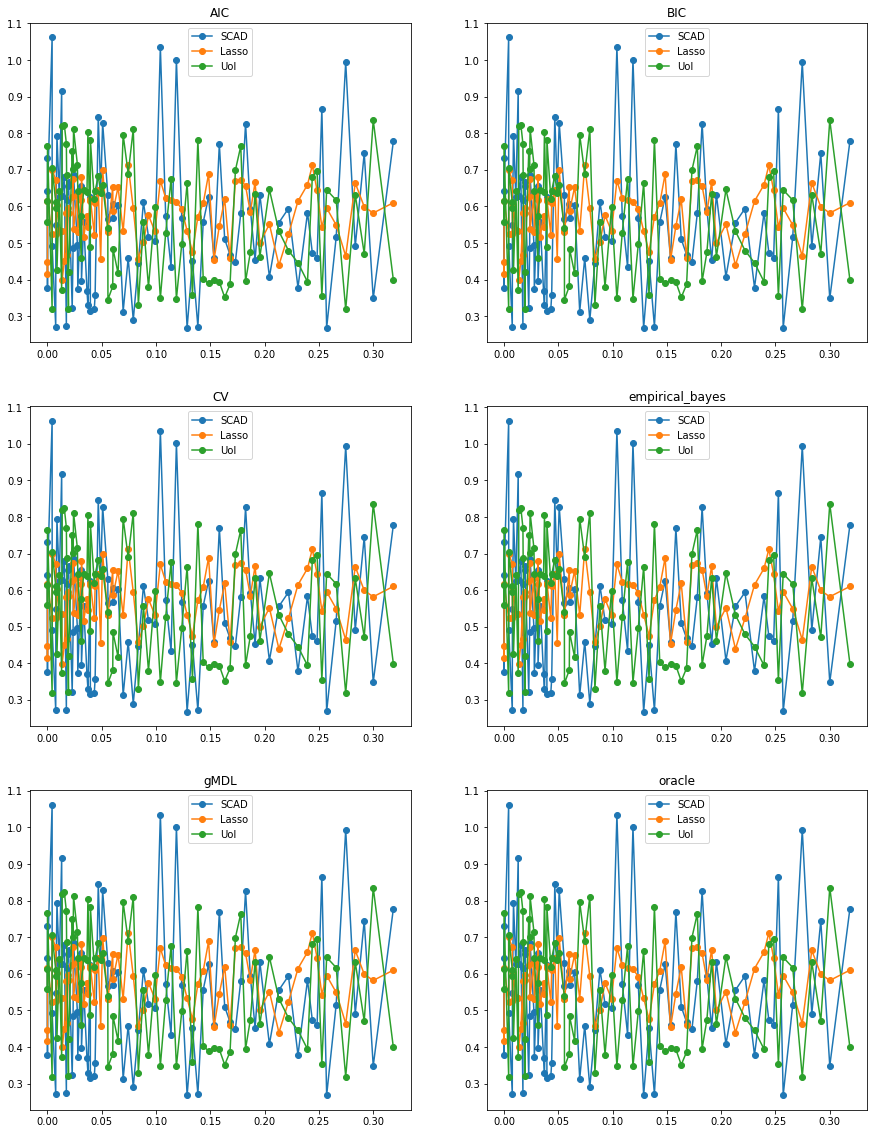

In [46]:
# Next, instead plot the normalized bias per element in the common support:

# Same plot, but average over reps

# Bias
fig, ax = plt.subplots(3, 2, figsize = (15, 20))

dframes = [scad2, lasso2, uoi2]
coeffs = [scadb, lassob, uoib]
dframe_names = ['SCAD', 'Lasso', 'UoI']
                
for i, sm in enumerate(np.unique(scad2['selection_method'].values)):

    a = ax[np.unravel_index(i, (3, 2))]

    for i2, df in enumerate(dframes):    
        df_ = apply_df_filters(df, selection_method=sm, sparsity=sparsity[0])
        
        ucp, cidxs = unique_cov_params(df_)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)
        values = normalized_bias(coeffs[i2], cidxs)
        a.plot(avg_cov[cov_order], values[cov_order], '-o', label=dframe_names[i2])

    a.set_title(sm)
    a.legend()


In [40]:
def raw_variance(cfile, cidxs):
    result = np.zeros(len(cidxs))    
    
    for i, cidx in enumerate(cidxs):
        bhat = cfile['beta_hat'][cidx, :]
        result[i] = np.linalg.norm(np.var(bhat, axis = 0))
    return result
    

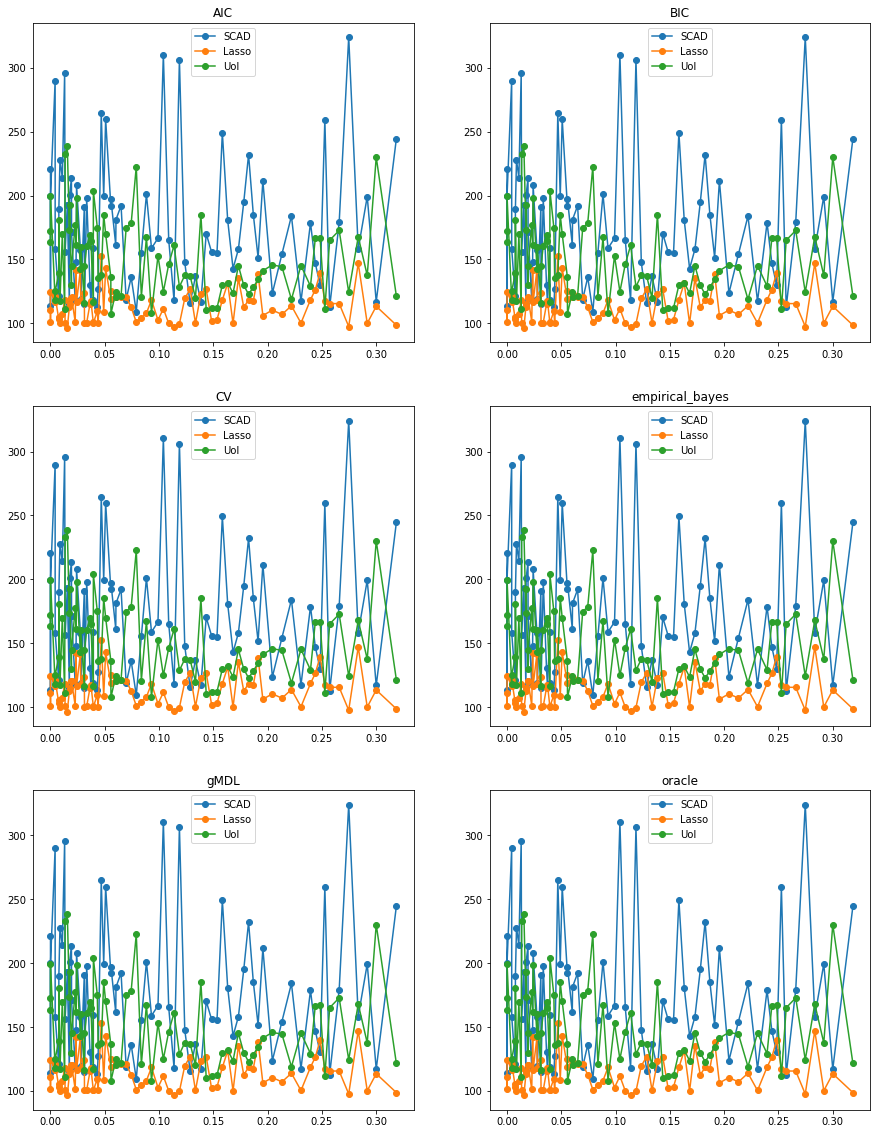

In [47]:
# Raw variance
# Next, instead plot the normalized bias per element in the common support:

# Same plot, but average over reps

# Bias
fig, ax = plt.subplots(3, 2, figsize = (15, 20))

dframes = [scad2, lasso2, uoi2]
coeffs = [scadb, lassob, uoib]
dframe_names = ['SCAD', 'Lasso', 'UoI']
                
for i, sm in enumerate(np.unique(scad2['selection_method'].values)):

    a = ax[np.unravel_index(i, (3, 2))]

    for i2, df in enumerate(dframes):    
        df_ = apply_df_filters(df, selection_method=sm, sparsity=sparsity[0])
        
        ucp, cidxs = unique_cov_params(df_)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)
        values = raw_variance(coeffs[i2], cidxs)
        a.plot(avg_cov[cov_order], values[cov_order], '-o', label=dframe_names[i2])

    a.set_title(sm)
    a.legend()


In [ ]:
# Evaluate how increasing the number of estimation bootstraps addresses variance

+
